<a href="https://colab.research.google.com/github/Caterina1996/SFEW_dataset/blob/master/SFEW_TF_VGG16_bo.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Transfer learning con VGG16 sin dataugmentation

In [8]:
from google.colab import drive
drive.mount('/content/gdrive/', force_remount=True)

Mounted at /content/gdrive/


In [9]:
#Load SFEW data:
!rm -rf SFEW_dataset

!git clone https://github.com/Caterina1996/SFEW_dataset



Cloning into 'SFEW_dataset'...
remote: Enumerating objects: 1327, done.
remote: Counting objects: 100% (1327/1327), done.
remote: Compressing objects: 100% (1315/1315), done.
remote: Total 1327 (delta 12), reused 1324 (delta 12), pack-reused 0
Receiving objects: 100% (1327/1327), 36.63 MiB | 52.46 MiB/s, done.
Resolving deltas: 100% (12/12), done.


In [10]:
import operator

import keras
import numpy as np
from keras.preprocessing.image import ImageDataGenerator
from keras.models import Sequential
from keras.layers import Dropout, Flatten, Dense, Conv2D, BatchNormalization, MaxPooling2D
from keras import applications

from keras.models import load_model
from keras.callbacks import ModelCheckpoint,CSVLogger

import numpy as np
import tensorflow as tf
from tensorflow.keras.layers import *
import sklearn.metrics as sk_metrics
from matplotlib import pyplot as plt
from sklearn.metrics import confusion_matrix
import itertools

import glob
import ntpath as nt
import os
from PIL import Image
import operator
from keras import optimizers

In [11]:
# load model without classifier layers
from keras.preprocessing.image import load_img
from keras.preprocessing.image import img_to_array
from keras.applications.vgg16 import preprocess_input
from keras.applications.vgg16 import decode_predictions
from keras.applications.vgg16 import VGG16
from keras.models import Model


In [12]:
pip install --upgrade wandb

  Using cached https://files.pythonhosted.org/packages/ca/5e/9df94df3bfee51b92b54a5e6fa277d6e1fcdf1f27b1872214b98f55ec0f7/wandb-0.10.12-py2.py3-none-any.whl
  Using cached https://files.pythonhosted.org/packages/83/d9/3d1f46b428fd7b646725896b58d2eddb84f79fd76912773e6193cf74263d/watchdog-1.0.2-py3-none-manylinux2014_x86_64.whl
  Using cached https://files.pythonhosted.org/packages/25/a6/2ecc1daa6a304e7f1b216f0896b26156b78e7c38e1211e9b798b4716c53d/shortuuid-1.0.1-py3-none-any.whl
  Using cached https://files.pythonhosted.org/packages/b1/5c/018bf9a5c24343a664deaea70e61f33f53bb1bd3caf193110f827bfd07e2/sentry_sdk-0.19.5-py2.py3-none-any.whl
Processing /root/.cache/pip/wheels/68/39/1a/5e402bdfdf004af1786c8b853fd92f8c4a04f22aad179654d1/subprocess32-3.5.4-cp36-none-any.whl
  Using cached https://files.pythonhosted.org/packages/24/d1/a7f8fe3df258549b303415157328bfcc63e9b11d06a7ad7a3327f3d32606/GitPython-3.1.11-py3-none-any.whl
  Using cached https://files.pythonhosted.org/packages/f5/e8/f6bd1ee

In [13]:
! wandb login f7a6ec99f94602934af48adb60b61fce29736c99

wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc


In [14]:
# Init wandb
import wandb
from wandb.keras import WandbCallback
wandb.init(project="FACES_TF")

wandb: Currently logged in as: caterina (use `wandb login --relogin` to force relogin)


In [15]:
img_width, img_height =128, 128 #revisar Las originales son 143 x 181
batch_size=2
wandb.config.learning_rate = 0.00001
epochs = 100
wandb.config.batch_size = 2
wandb.config.architecture='VGG16'
wandb.config.img_width, wandb.config.img_height=img_width, img_height
num_classes=7
dropout = 0.25
dataugmentation=False

train_dir='SFEW_dataset/Train'
test_dir='SFEW_dataset/Val'

In [16]:
def create_sets(dataugmentation,train_data_dir,validation_data_dir,batch_size):

  if dataugmentation==True:
    train_datagen = ImageDataGenerator(rescale=1. / 255,
                                   brightness_range=[0.5,1.0],
                                   zoom_range=0.1,
                                   shear_range=0.2,
                                  #  height_shift_range=0.1,
                                   horizontal_flip=True)
                                  #  height_shift_range=0.1
  else:

    train_datagen = ImageDataGenerator(rescale=1. / 255)

  test_datagen= ImageDataGenerator(rescale=1. / 255)

  train_set = train_datagen.flow_from_directory(
    train_data_dir,
    target_size=(wandb.config.img_width, wandb.config.img_height),
    batch_size=batch_size,
    class_mode='categorical',
    # color_mode='grayscale',
    shuffle=True)
  
  test_set = test_datagen.flow_from_directory(
    validation_data_dir,
    target_size=(wandb.config.img_width, wandb.config.img_height),
    batch_size=batch_size,
    class_mode='categorical',
    # color_mode='grayscale',
    shuffle=True)
  
  return train_set,test_set

In [17]:
train_set,test_set=create_sets(dataugmentation,train_dir,test_dir,wandb.config.batch_size)

nb_train_samples = len(train_set.filenames)
nb_test_samples = len(test_set.filenames)

train_set.class_indices
emotions_dict = {v: k for k, v in train_set.class_indices.items()}
print(emotions_dict)

Found 859 images belonging to 7 classes.
Found 405 images belonging to 7 classes.
{0: 'Angry', 1: 'Disgust', 2: 'Fear', 3: 'Happy', 4: 'Neutral', 5: 'Sad', 6: 'Surprise'}


In [18]:
# VGG = VGG16(include_top=False, input_shape=(img_width, img_height, 3))
# VGG.summary()

In [19]:
# model.summary()

In [20]:
# #Reentrenaremos solo el último bloque convolucional
# for layer in model.layers[-1:-11]:
#   print(layer.name)


In [21]:
wandb.config.num_frozen_layers=-11
wandb.config.dataug=False

In [22]:
def get_emo(prediction):
  emo=list(prediction).index(1)
  return emotions_dict[emo]

{0: 'Angry', 1: 'Disgust', 2: 'Fear', 3: 'Happy', 4: 'Neutral', 5: 'Sad', 6: 'Surprise'}
Surprise


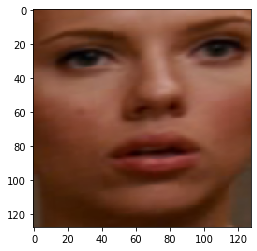

Surprise


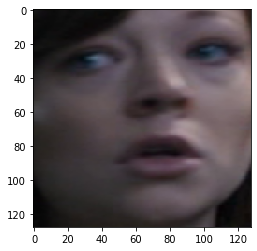

In [23]:

emotions_dict = {v: k for k, v in train_set.class_indices.items()}
print(emotions_dict)

import tensorflow as tf
x,y = train_set.next()
for i in range(len(x)):
    image = x[i]
    plt.imshow( tf.squeeze(image))
    print(get_emo(y[i]))
    plt.show()

In [24]:
def create_model(num_frozen_layers,dropout=None):
  model = VGG16(include_top=False, input_shape=(img_width, img_height, 3))
  print("VGG_summary:")
  model.summary()
  # add new classifier layers
  flat1 = Flatten()(model.layers[-1].output)
  dense1 = Dense(1024, activation='relu')(flat1)
  if dropout!=None:
    dropout=Dropout(dropout)(dense1)
    output = Dense(7, activation='softmax')(dropout)
  else:
    output = Dense(7, activation='softmax')(dense1)
  # define new model
  new_model = Model(inputs=model.inputs, outputs=output)
  print(new_model.layers)
  for layer in new_model.layers[-num_frozen_layers:-4]:
    print("freezing layer: ",layer.name)
    layer.trainable = False

  print("new_model summary!")
  new_model.summary()
  return new_model

In [25]:
def compile_and_train(model,learning_rate,epochs,filepath,batch_size):

  model.compile(loss='binary_crossentropy',
                optimizer=optimizers.SGD(lr=1e-4, momentum=0.9),
                metrics=['accuracy','categorical_accuracy'])


  path=filepath+":{epoch:03d}-val_accuracy:{val_accuracy:.3f}.hdf5"
  checkpoint = ModelCheckpoint(filepath, monitor='val_accuracy', verbose=1, save_best_only=True, mode='max')

  E_stopping=tf.keras.callbacks.EarlyStopping(monitor="val_accuracy",
                                              min_delta=0,
                                              patience=50,
                                              verbose=1,
                                              mode="auto",
                                              restore_best_weights=True)
  WandbCallbacks=WandbCallback(
                monitor='val_loss',
                verbose=1,
                mode='auto',
                generator=test_set,
                validation_steps=nb_test_samples // batch_size,
                input_type="image",
                labels=['Angry', 'Disgust', 'Fear', 'Happy', 'Neutral', 'Sad', 'Surprise'])

  callbacks_list = [checkpoint,E_stopping,WandbCallbacks]


  history=model.fit_generator(
          train_set,
          steps_per_epoch=nb_train_samples // batch_size,
          epochs=epochs,
          validation_data=test_set,
          validation_steps=nb_test_samples // batch_size,
          callbacks=callbacks_list)
  
  return history

In [26]:
def plot_model(history,title):
  plt.figure()
  plt.plot(history.history['accuracy'])
  plt.plot(history.history['val_accuracy'])
  # plt.plot(history.history['val_categorical_accuracy'])
  plt.ylabel('accuracy')
  plt.xlabel('epoch')
  plt.legend(['train', 'val'], loc='upper left')

  plt.title("model train and val accuracy "+title)
  # plt.show()
  
  plt.figure()
  plt.plot(history.history['val_accuracy'])
  plt.title("Validation accuracy " + title)

  plt.figure()
  plt.plot(history.history['val_categorical_accuracy'])
  plt.title("Validation categorical accuracy"+title)
  # print(history.history.keys())

In [28]:
#batch_size=16, lr=0.00001 dropout = 0.25
#Prueba 3 reentrenar 2 bloques convolucionales y dropout 0.5
test_num="3"
dir="/content/gdrive/MyDrive/TF_VGG16/Prueba"+test_num

os.makedirs(dir)

wandb.config.dropout = 0.25
wandb.config.LR = 0.0001

wandb.config.epochs = 150
batch_sz=[2,16,32,64,128]
# batch_size=list(batch_sz).reverse()
# print(batch_size)
batch_size=2
dataugmentation=False

model3=create_model(16,0.5)
model3.summary()
len(model3.layers)

train_set,test_set=create_sets(dataugmentation,train_dir,test_dir,wandb.config.batch_size)
nb_train_samples = len(train_set.filenames)
nb_test_samples = len(test_set.filenames)

history=compile_and_train(model3,wandb.config.LR,wandb.config.epochs,dir,batch_size)
model3.save(dir+'/SFEW_TF_3.h5')
title="SFEW_Transfer_learning using VGG16"
plot_model(history,title)
model.save("model.h5")

FileExistsError: ignored

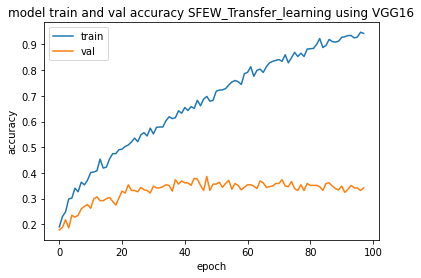

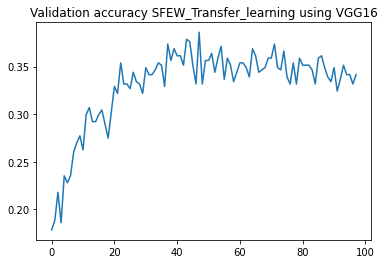

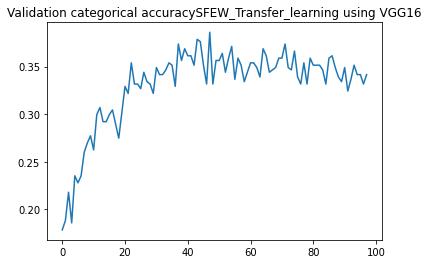

In [30]:
model3.save(dir+'/SFEW_TF_3.h5')
title="SFEW_Transfer_learning using VGG16"
plot_model(history,title)
model3.save("model.h5")

In [32]:
model3.save('gdrive/My Drive/TFM_VGG16/Prueba3.h5')

In [36]:
datagen = ImageDataGenerator(rescale=1. / 255)
test_set = datagen.flow_from_directory(
    'SFEW_dataset/Val',
    target_size=(img_width, img_height),
    batch_size=1,
    class_mode='categorical',
    shuffle=False)

predictions=model3.predict(test_set)

print('Confusion Matrix')
ypred=[round(list(i).index(max(i))) for i in predictions]
print(confusion_matrix(test_set.classes, ypred)[:,:])



for i in range(0,6):
 print(list(test_set.labels).count(i))

model3.evaluate_generator(test_set)

Found 405 images belonging to 7 classes.
Confusion Matrix
[[36  1  0 13  9 15  2]
 [ 6  0  0  3  4  9  1]
 [16  0  0  4 11 12  2]
 [ 5  0  0 46  5  3  3]
 [ 7  0  1  5 50 15  4]
 [ 9  0  3 12 23 18  3]
 [14  0  1  5 10 12  7]]
76
23
45
62
82
68


/usr/local/lib/python3.6/dist-packages/tensorflow/python/keras/engine/training.py:1877: UserWarning: `Model.evaluate_generator` is deprecated and will be removed in a future version. Please use `Model.evaluate`, which supports generators.
  warnings.warn('`Model.evaluate_generator` is deprecated and '


[0.38174399733543396, 0.3876543343067169, 0.3876543343067169]

In [37]:
prediction=predictions[0]
def get_predicted_emo(prediction):
  emo=list(prediction).index(max(list(prediction)))
  print(prediction)
  return emotions_dict[emo]
  
get_predicted_emo(prediction)

predictions.shape

[0.94059217 0.00695776 0.00528302 0.01419774 0.00621291 0.00543731
 0.02131913]


(405, 7)

Found 405 images belonging to 7 classes.
Confusion Matrix
[[36  1  0 13  9 15  2]
 [ 6  0  0  3  4  9  1]
 [16  0  0  4 11 12  2]
 [ 5  0  0 46  5  3  3]
 [ 7  0  1  5 50 15  4]
 [ 9  0  3 12 23 18  3]
 [14  0  1  5 10 12  7]]
76
23
45
62
82
68
{0: 'Angry', 1: 'Disgust', 2: 'Fear', 3: 'Happy', 4: 'Neutral', 5: 'Sad', 6: 'Surprise'}
Angry
[0.94059217 0.00695776 0.00528302 0.01419774 0.00621291 0.00543731
 0.02131913]
Angry


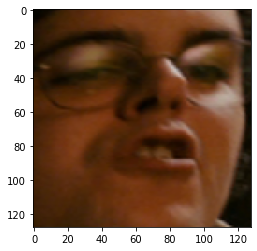

Angry
[0.94059217 0.00695776 0.00528302 0.01419774 0.00621291 0.00543731
 0.02131913]
Angry


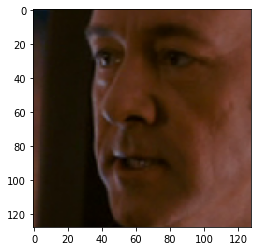

Angry
[0.94059217 0.00695776 0.00528302 0.01419774 0.00621291 0.00543731
 0.02131913]
Angry


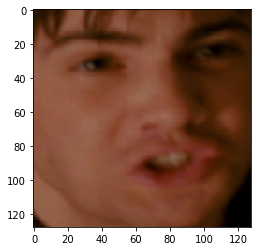

Angry
[0.94059217 0.00695776 0.00528302 0.01419774 0.00621291 0.00543731
 0.02131913]
Angry


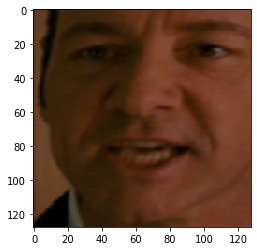

Angry
[0.94059217 0.00695776 0.00528302 0.01419774 0.00621291 0.00543731
 0.02131913]
Angry


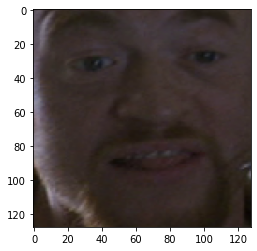

Angry
[0.94059217 0.00695776 0.00528302 0.01419774 0.00621291 0.00543731
 0.02131913]
Angry


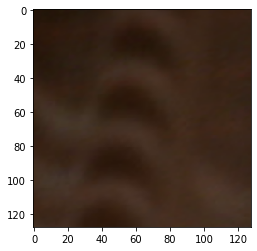

Angry
[0.94059217 0.00695776 0.00528302 0.01419774 0.00621291 0.00543731
 0.02131913]
Angry


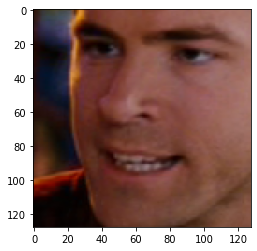

Angry
[0.94059217 0.00695776 0.00528302 0.01419774 0.00621291 0.00543731
 0.02131913]
Angry


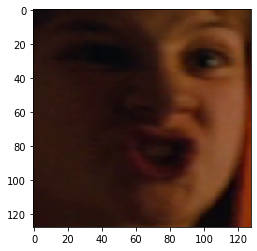

Angry
[0.94059217 0.00695776 0.00528302 0.01419774 0.00621291 0.00543731
 0.02131913]
Angry


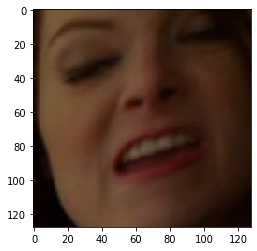

Angry
[0.94059217 0.00695776 0.00528302 0.01419774 0.00621291 0.00543731
 0.02131913]
Angry


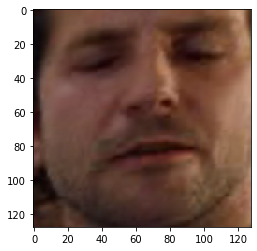

Angry
[0.94059217 0.00695776 0.00528302 0.01419774 0.00621291 0.00543731
 0.02131913]
Angry


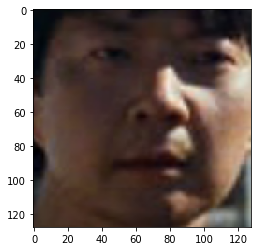

Angry
[0.94059217 0.00695776 0.00528302 0.01419774 0.00621291 0.00543731
 0.02131913]
Angry


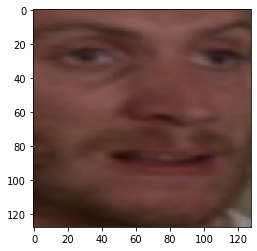

Angry
[0.94059217 0.00695776 0.00528302 0.01419774 0.00621291 0.00543731
 0.02131913]
Angry


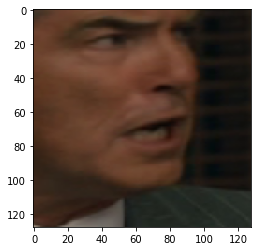

Angry
[0.94059217 0.00695776 0.00528302 0.01419774 0.00621291 0.00543731
 0.02131913]
Angry


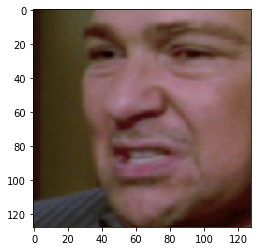

Angry
[0.94059217 0.00695776 0.00528302 0.01419774 0.00621291 0.00543731
 0.02131913]
Angry


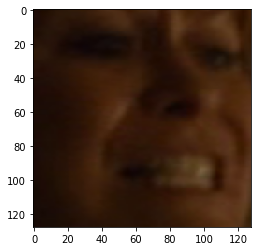

In [55]:
test_set = datagen.flow_from_directory(
    'SFEW_dataset/Val',
    target_size=(img_width, img_height),
    batch_size=128,
    class_mode='categorical',
    shuffle=False)


predictions=model3.predict(test_set)

print('Confusion Matrix')
ypred=[round(list(i).index(max(i))) for i in predictions]
print(confusion_matrix(test_set.classes, ypred)[:,:])

#Predice siempre fear :/
test_set.labels

for i in range(0,6):
 print(list(test_set.labels).count(i))


emotions_dict = {v: k for k, v in train_set.class_indices.items()}
print(emotions_dict)

import tensorflow as tf
x,y = test_set.next()

for i in range(15):
    
    image = x[i*5]
    plt.imshow( tf.squeeze(image),cmap='gray')
    print(get_emo(y[i*5]))
    print(get_predicted_emo(prediction))
    plt.show()

In [49]:
test_set.labels

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3,
       3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3,
       3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3,
       3, 3, 3, 3, 3, 3, 3, 3, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4,
       4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4,
       4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4,
       4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4,
       4, 4, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5,

In [ ]:
stop

In [ ]:
#batch_size=16, lr=0.00001 dropout = 0.25
#Prueba 0 test batch_size
test_num="0"
dir="/content/gdrive/MyDrive/TF_VGG16/Prueba"+test_num

os.makedirs(dir)

wandb.config.dropout = 0.25
wandb.config.LR = 0.0001

wandb.config.epochs = 150
batch_sz=[2,16,32,64,128]
# batch_size=list(batch_sz).reverse()
# print(batch_size)
batch_size=2
dataugmentation=False

model=create_model(11)
model.summary()
len(model.layers)

train_set,test_set=create_sets(dataugmentation,train_dir,test_dir,wandb.config.batch_size)
nb_train_samples = len(train_set.filenames)
nb_test_samples = len(test_set.filenames)

In [ ]:


history=compile_and_train(model,wandb.config.LR,wandb.config.epochs,dir,batch_size)
model.save(dir+'/SFEW_TF_0.h5')
title="SFEW_Transfer_learning using VGG16"
plot_model(history,title)
model.save("model.h5")

In [ ]:
#batch_size=16, lr=0.00001 dropout = 0.25
#Prueba 0 test batch_size
test_num="2"
dir="/content/gdrive/MyDrive/TF_VGG16/Prueba"+test_num

os.makedirs(dir)

wandb.config.dropout = 0.25
wandb.config.LR = 0.0001

wandb.config.epochs = 150
batch_sz=[2,16,32,64,128]
# batch_size=list(batch_sz).reverse()
# print(batch_size)
batch_size=2
dataugmentation=False

model=create_model(11,0.35)
model.summary()
len(model.layers)

train_set,test_set=create_sets(dataugmentation,train_dir,test_dir,wandb.config.batch_size)
nb_train_samples = len(train_set.filenames)
nb_test_samples = len(test_set.filenames)

history=compile_and_train(model,wandb.config.LR,wandb.config.epochs,dir,batch_size)
model.save(dir+'/SFEW_TF_0.h5')
title="SFEW_Transfer_learning using VGG16"
plot_model(history,title)
model.save("model.h5")



In [ ]:
stop

In [ ]:


for layer in model.layers[:-11]:
        layer.trainable = False



# compile the model with a SGD/momentum optimizer
# and a very slow learning rate.
model.compile(loss='binary_crossentropy',
              optimizer=optimizers.SGD(lr=1e-4, momentum=0.9),
              metrics=['accuracy','categorical_accuracy'])

filepath="gdrive/My Drive/TFM_MUSI/:{epoch:03d}-val_accuracy:{val_accuracy:.3f}.hdf5"
checkpoint = ModelCheckpoint(filepath, monitor='val_accuracy', verbose=1, save_best_only=True, mode='max')
E_stopping=tf.keras.callbacks.EarlyStopping(monitor="val_loss",
                                            min_delta=0,
                                            patience=15,
                                            verbose=1,
                                            mode="auto",
                                            restore_best_weights=True)
WandbCallbacks=WandbCallback(
              monitor='val_loss',
              verbose=1,
              mode='auto',
              generator=test_generator,
              validation_steps=nb_validation_samples // batch_size,
              input_type="image",
              labels=['Angry', 'Disgust', 'Fear', 'Happy', 'Neutral', 'Sad', 'Surprise'])

callbacks_list = [checkpoint,E_stopping,WandbCallbacks]


history=model.fit_generator(
        train_generator,
        steps_per_epoch=nb_train_samples // batch_size,
        epochs=epochs,
        validation_data=test_generator,
        validation_steps=nb_validation_samples // batch_size,
        callbacks=callbacks_list)

In [ ]:
model.save('gdrive/My Drive/TFM_MUSI/FacesTF1.h5')

In [ ]:
test_set = datagen.flow_from_directory(
    'SFEW_dataset/Val',
    target_size=(img_width, img_height),
    batch_size=1,
    class_mode='categorical',
    shuffle=False)

predictions=model.predict(test_set)

print('Confusion Matrix')
ypred=[round(list(i).index(max(i))) for i in predictions]
print(confusion_matrix(test_set.classes, ypred)[:,:])

#Predice siempre fear :/
test_set.labels

for i in range(0,6):
 print(list(test_set.labels).count(i))

model.evaluate_generator(test_set)

In [ ]:
prediction=predictions[0]
def get_predicted_emo(prediction):
  emo=list(prediction).index(max(list(prediction)))
  print(prediction)
  return emotions_dict[emo]
get_predicted_emo(prediction)

predictions.shape

In [ ]:
test_set = datagen.flow_from_directory(
    'SFEW_dataset/Val',
    target_size=(img_width, img_height),
    batch_size=1,
    class_mode='categorical',
    shuffle=False)


predictions=model.predict(test_set)

print('Confusion Matrix')
ypred=[round(list(i).index(max(i))) for i in predictions]
print(confusion_matrix(test_set.classes, ypred)[:,:])

#Predice siempre fear :/
test_set.labels

for i in range(0,6):
 print(list(test_set.labels).count(i))


emotions_dict = {v: k for k, v in train_generator.class_indices.items()}
print(emotions_dict)

import tensorflow as tf

for i in range(15):
    
    image = x[i]
    plt.imshow( tf.squeeze(image),cmap='gray')
    print(get_emo(y[i]))
    print(get_predicted_emo(prediction))
    plt.show()

In [ ]:
model.save('FACESTF1.h5')